# Collaboration and Competition

---

This notebook corresponds to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program where the task is to solve the Tennis environment provided by Unity. The baseline of the code was provided by Udacity.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# env.close()

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the agent

Run the code below to solve the environment. The environment is considered solved when it reaches an average score of +0.5 in the last 100 episodes.

In [6]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [7]:
def ddpg(n_episodes=3000, max_t = 3000, learn_every=5, num_learn=10, goal=0.5):
    scores_window = deque(maxlen=100)
    scores1 = []
    scores2 = []
    scores = []
    max_score = -np.Inf
    
    
    agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=17)
    agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=17)    

    agent2.critic_local = agent1.critic_local
    agent2.critic_target = agent1.critic_target
    agent2.critic_optimizer = agent1.critic_optimizer

    agent2.actor_local = agent1.actor_local
    agent2.actor_target = agent1.actor_target
    agent2.actor_optimizer = agent1.actor_optimizer

    agent2.memory = agent1.memory
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        score1 = 0
        score2 = 0
#         while True:
        for t in range(max_t):
            state1 = state[0]
            state2 = state[1]
            state1 = state1.reshape((1,state.shape[1]))
            state2 = state2.reshape((1,state.shape[1]))
            
            action1 = agent1.act(state1)
            action2 = agent1.act(state2)
            env_info = env.step([action1, action2])[brain_name]        
            next_state = env_info.vector_observations   
            reward = env_info.rewards                   
            done = env_info.local_done                  
            
            next_state1 = next_state[0]
            next_state2 = next_state[1]
            
            for s, a, r, n_s, d in zip(state, [action1, action2], reward, next_state, done):
                agent1.add_memory(s, a, r, n_s, d)
                agent2.add_memory(s, a, r, n_s, d)

            state = next_state
            score1 += reward[0]
            score2 += reward[1]
                        
            if t%learn_every == 0:
                for _ in range(num_learn):
                    agent1.step()
                    agent2.step()
            
            if np.all(done):
                break 
        
        scores1.append(score1)
        scores2.append(score2)
        
        score_max = np.max([score1,score2])
        scores_window.append(score_max)
        scores.append(score_max)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window), score_max), end="")
        if i_episode % 100 == 0:
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor_2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic_2.pth')            
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))   
        if np.mean(scores_window)>=goal:
            print('\nEnvironment solved after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor_2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic_2.pth')
            break
    return scores

In [8]:
scores = ddpg()


Episode 100	Average Score: 0.13	Score: 0.40
Episode 200	Average Score: 0.31	Score: 0.20
Episode 300	Average Score: 0.49	Score: 2.10
Episode 307	Average Score: 0.51	Score: 1.70
Environment solved after 307 episodes!	Average Score: 0.51


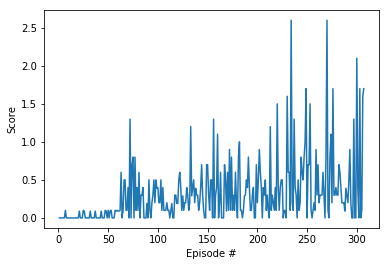

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [10]:
import pandas as pd
df = pd.DataFrame(scores)
df.to_csv('scores_df.csv')